# Colour Correction using Splines

### Define constants

In [4]:
%load_ext autoreload
%autoreload 2
import colour
from data import load_dataset_sfu, load_dataset_csv, load_illuminant_cmfs, load_camera
import numpy as np

RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)

SFU_FILE_PATH = 'reflect_db.reflect'
CAVE_FOSTER2004_PATH = 'cave_foster2004.csv'
FOSTER_50_PATH = 'foster50.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
sfu_dataset = load_dataset_sfu(SFU_FILE_PATH)
cave_foster2004_dataset = load_dataset_csv(CAVE_FOSTER2004_PATH)
foster_50_dataset = load_dataset_csv(FOSTER_50_PATH)

TRAIN = cave_foster2004_dataset
TEST = foster_50_dataset
VALIDATION = sfu_dataset
CAMERA = 'sigma'

### Spectral sensitivities of various cameras

In [6]:

MSDS_TRAIN, SDS_TRAIN = load_camera(CAMERA)


### Computing Observer Responses
We can easily change the order of test and train sets here

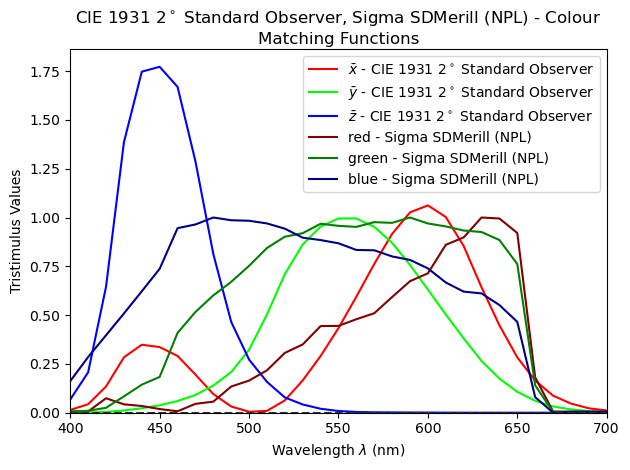

In [7]:
illuminant, cmfs = load_illuminant_cmfs()
colour.plotting.plot_multi_cmfs([MSDS_TRAIN, cmfs])
response_trainset_xyz = colour.characterisation.training_data_sds_to_XYZ(TRAIN, cmfs, illuminant)
response_testset_xyz = colour.characterisation.training_data_sds_to_XYZ(TEST, cmfs, illuminant)
response_validation_xyz = colour.characterisation.training_data_sds_to_XYZ(VALIDATION, cmfs, illuminant)

### Chromaticity Diagrams

/Users/jsuominen/anaconda3/envs/colour-calibration/lib/python3.11/site-packages/colour/utilities/verbose.py:265: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028
/Users/jsuominen/anaconda3/envs/colour-calibration/lib/python3.11/site-packages/colour/utilities/verbose.py:265: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028


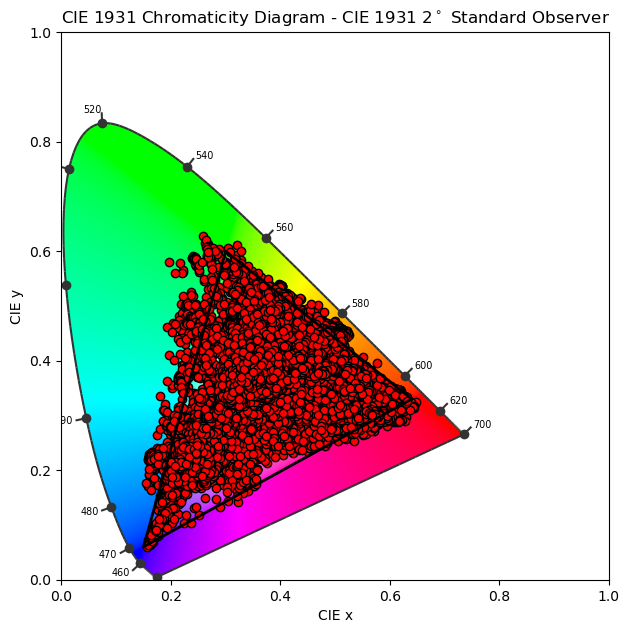

/Users/jsuominen/anaconda3/envs/colour-calibration/lib/python3.11/site-packages/colour/utilities/verbose.py:265: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028
/Users/jsuominen/anaconda3/envs/colour-calibration/lib/python3.11/site-packages/colour/utilities/verbose.py:265: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028


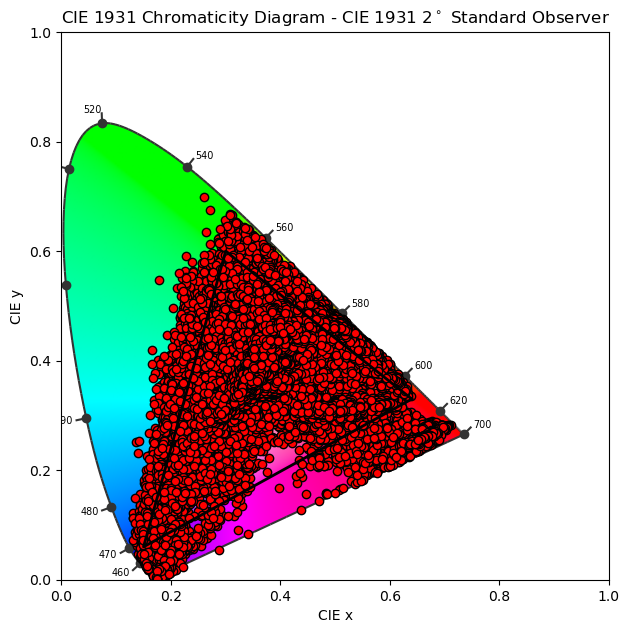

/Users/jsuominen/anaconda3/envs/colour-calibration/lib/python3.11/site-packages/colour/utilities/verbose.py:265: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028
/Users/jsuominen/anaconda3/envs/colour-calibration/lib/python3.11/site-packages/colour/utilities/verbose.py:265: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028


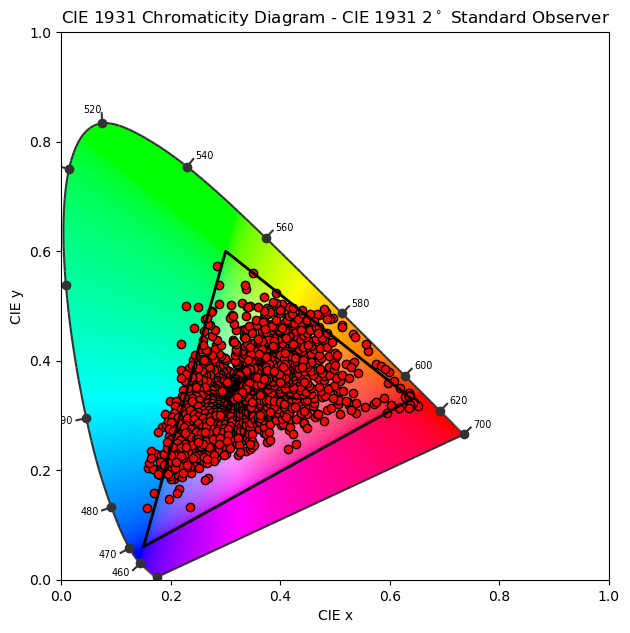

In [8]:
from plotting import plot_chromaticity_diagram
plot_chromaticity_diagram(response_trainset_xyz)
plot_chromaticity_diagram(response_testset_xyz)
plot_chromaticity_diagram(response_validation_xyz)

### Computing Camera Responses

In [9]:
response_trainset_camera, _ = colour.characterisation.training_data_sds_to_RGB(TRAIN, MSDS_TRAIN, SDS_TRAIN)
response_testset_camera, _ = colour.characterisation.training_data_sds_to_RGB(TEST, MSDS_TRAIN, SDS_TRAIN)
response_validationset_camera,  _ = colour.characterisation.training_data_sds_to_RGB(VALIDATION, MSDS_TRAIN, SDS_TRAIN)

### Fit Generalized Additive Model with P-splines

In [10]:
from sklearn.metrics import make_scorer
from colour_math import deltae_mean
from models import GAMOptimizer
from evaluate import pred
from skopt import BayesSearchCV
np.int = np.int64

gam = GAMOptimizer(lams=1e-5,order=3, n_splines=20)

gam.fit(response_trainset_camera, response_trainset_xyz)

pred(gam, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")
pred(gam, response_validationset_camera, response_validation_xyz, "DeltaE SFU")

---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 1.6395784105495474
DeltaE max: 17.613503230346133
DeltaE min: 0.004981571284975372
DeltaE median: 1.3572835593048531
DeltaE 95 percentile: 3.902833179558448
DeltaE 99 percentile: 6.05290621404854
---- RESULTS DeltaE SFU ----
DeltaE mean: 1.8414721954507163
DeltaE max: 22.31947353791431
DeltaE min: 0.1290847418518021
DeltaE median: 1.4803123766369966
DeltaE 95 percentile: 4.400516220728709
DeltaE 99 percentile: 6.949538949557216


### Fit Linear Model

In [11]:
from sklearn.linear_model import LinearRegression

linear = LinearRegression()


linear.fit(response_trainset_camera, response_trainset_xyz)
pred(linear, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")
pred(linear, response_validationset_camera, response_validation_xyz, "DeltaE SFU")

---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 2.82028884762708
DeltaE max: 19.607047269647527
DeltaE min: 0.027020350410030588
DeltaE median: 2.0706539124125367
DeltaE 95 percentile: 8.204764763813639
DeltaE 99 percentile: 9.865595597155483
---- RESULTS DeltaE SFU ----
DeltaE mean: 1.9825198709798244
DeltaE max: 22.29786227813668
DeltaE min: 0.11641576623188139
DeltaE median: 1.5586637268030548
DeltaE 95 percentile: 4.693046301639656
DeltaE 99 percentile: 7.196443659236854


### Fit 3rd order Root-Polynomial Model

In [12]:
from models import PolynomialTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

RP_linear_3 = Pipeline([
    ('transformer', PolynomialTransformer(degree=3, rp=True)),
    ('regressor', LinearRegression())
])


RP_linear_3.fit(response_trainset_camera, response_trainset_xyz)
pred(RP_linear_3, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")
pred(RP_linear_3, response_validationset_camera, response_validation_xyz, "DeltaE SFU")

---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 2.3964327385859714
DeltaE max: 35.11783762216667
DeltaE min: 0.015229385350929029
DeltaE median: 1.8229389807737906
DeltaE 95 percentile: 6.363901133919155
DeltaE 99 percentile: 8.603383234777075
---- RESULTS DeltaE SFU ----
DeltaE mean: 1.5851532497817027
DeltaE max: 16.790768725495738
DeltaE min: 0.08990439059588122
DeltaE median: 1.259038147416405
DeltaE 95 percentile: 3.938489556605737
DeltaE 99 percentile: 6.042281175724155


### Fit a 2nd order Root-Polynomial Model

In [13]:
from models import GAMOptimizer, PolynomialTransformer, DeltaEOptimizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

RP_linear_2 = Pipeline([
    ('transformer', PolynomialTransformer(degree=2, rp=True)),
    ('regressor', LinearRegression())
])


RP_linear_2.fit(response_trainset_camera, response_trainset_xyz)
pred(RP_linear_2, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")
pred(RP_linear_2, response_validationset_camera, response_validation_xyz, "DeltaE SFU")

---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 2.393974855988917
DeltaE max: 25.82306916256862
DeltaE min: 0.007835525880333845
DeltaE median: 1.8029469964985188
DeltaE 95 percentile: 6.586393781609532
DeltaE 99 percentile: 8.758044692428225
---- RESULTS DeltaE SFU ----
DeltaE mean: 1.688091868085644
DeltaE max: 10.314207865260999
DeltaE min: 0.05434512488357087
DeltaE median: 1.4026997133765606
DeltaE 95 percentile: 3.907566986212277
DeltaE 99 percentile: 5.566635052243249


In [14]:
P_Linear_3 = Pipeline([
    ('transformer', PolynomialTransformer(degree=3, rp=False)),
    ('regressor', LinearRegression())
])


P_Linear_3.fit(response_trainset_camera, response_trainset_xyz)
pred(P_Linear_3, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")
pred(P_Linear_3, response_validationset_camera, response_validation_xyz, "DeltaE SFU")

---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 2.1367402402691926
DeltaE max: 18.91352819262478
DeltaE min: 0.03056737244817451
DeltaE median: 1.648653080384026
DeltaE 95 percentile: 5.432763928924784
DeltaE 99 percentile: 6.995379297355632
---- RESULTS DeltaE SFU ----
DeltaE mean: 1.713192946975639
DeltaE max: 11.71300133580808
DeltaE min: 0.09147494021461858
DeltaE median: 1.4306185895540446
DeltaE 95 percentile: 3.9250403129647697
DeltaE 99 percentile: 5.875995079725191


In [15]:
P_linear = Pipeline([
    ('transformer', PolynomialTransformer(degree=2, rp=False)),
    ('regressor', LinearRegression())
])


P_linear.fit(response_trainset_camera, response_trainset_xyz)
pred(P_linear, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")
pred(P_linear, response_validationset_camera, response_validation_xyz, "DeltaE SFU")

---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 2.3480084448699166
DeltaE max: 19.34800138148044
DeltaE min: 0.022913482592196447
DeltaE median: 1.8008974616868065
DeltaE 95 percentile: 6.223503091632903
DeltaE 99 percentile: 7.664169332373443
---- RESULTS DeltaE SFU ----
DeltaE mean: 1.7999651746267553
DeltaE max: 13.573275287377616
DeltaE min: 0.0636870540213465
DeltaE median: 1.471535094383302
DeltaE 95 percentile: 4.219204387699271
DeltaE 99 percentile: 6.001525612030837



DE2000RP = Pipeline([
    ('regressor', DeltaEOptimizer(root_polynomial=True, degree=3))
])


DE2000RP.fit(response_trainset_camera, response_trainset_xyz)
pred(DE2000RP, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")
pred(DE2000RP, response_validationset_camera, response_validation_xyz, "DeltaE SFU")

In [16]:

DE2000RP = Pipeline([
    ('regressor', DeltaEOptimizer(root_polynomial=False, degree=1))
])


#DE2000RP.fit(response_trainset_camera, response_trainset_xyz)
#pred(DE2000RP, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")
#pred(DE2000RP, response_validationset_camera, response_validation_xyz, "DeltaE SFU")

In [17]:
import colour
import matplotlib.pyplot as plt
import numpy as np

# Retrieve the XYZ colour matching functions.
cmfs = colour.colorimetry.MSDS_CMFS['CIE 1931 2 Degree Standard Observer']

# Wavelengths of the standard observer.
wavelengths = cmfs.wavelengths

# Converting XYZ to sRGB sensitivities
# sRGB colour matching functions are derived from the XYZ ones by applying the sRGB colour space matrix.
rgb_colourspace = colour.RGB_COLOURSPACES['sRGB']
matrix_XYZ_to_RGB = rgb_colourspace.matrix_XYZ_to_RGB

# Applying the matrix to each XYZ sensitivity
sRGB_sensitivities = np.dot(cmfs.values, matrix_XYZ_to_RGB.T)

# Plotting the sensitivities
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, sRGB_sensitivities[:, 0], label='Red', color='r')
plt.plot(wavelengths, sRGB_sensitivities[:, 1], label='Green', color='g')
plt.plot(wavelengths, sRGB_sensitivities[:, 2], label='Blue', color='b')
plt.title('sRGB Sensitivities')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Response')
plt.legend()
plt.grid(True)


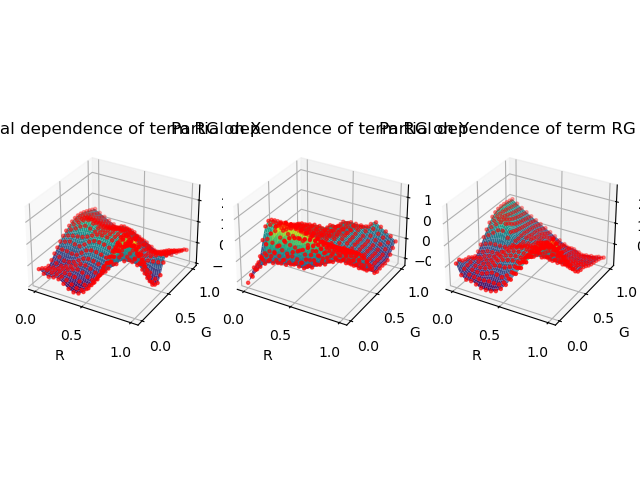

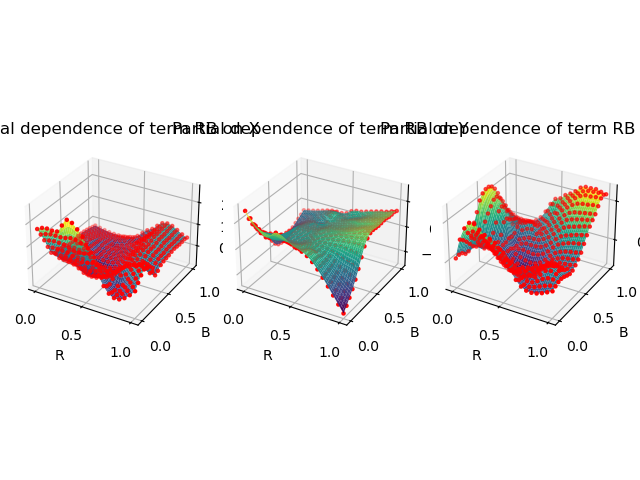

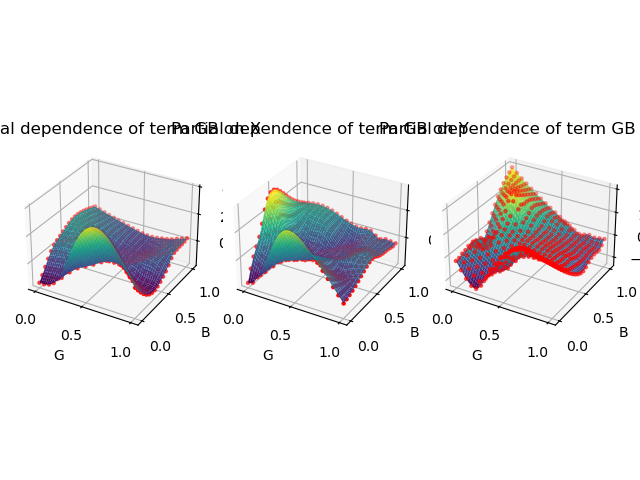

In [18]:
%matplotlib ipympl

gam.plot_partial_dependences()

In [19]:
from models import GAMOptimizer
from evaluate import pred
from sklearn.pipeline import Pipeline
from models import PolynomialTransformer
from sklearn.linear_model import LinearRegression
from colour import SpectralShape
from colour import MSDS_CAMERA_SENSITIVITIES, MSDS_CMFS
import numpy as np
#spectra = Pipeline([
#    ('transformer', PolynomialTransformer(degree=3, rp=False)),
#    ('regressor', LinearRegression())
# ])

spectra = GAMOptimizer(lams=1e-3, order=3, n_splines=20)


cmfs = MSDS_CMFS['CIE 1931 2 Degree Standard Observer'].copy()
MSDS_TRAIN = MSDS_CAMERA_SENSITIVITIES['Nikon 5100 (NPL)']
cmfs.values = cmfs.values / np.max(cmfs.values)
source = MSDS_TRAIN.align(SpectralShape(400, 700, 1)).values
target = cmfs.align(SpectralShape(400, 700, 1)).values
print(MSDS_TRAIN.wavelengths)
spectra.fit(source, target)

[ 400.  401.  402.  403.  404.  405.  406.  407.  408.  409.  410.  411.
  412.  413.  414.  415.  416.  417.  418.  419.  420.  421.  422.  423.
  424.  425.  426.  427.  428.  429.  430.  431.  432.  433.  434.  435.
  436.  437.  438.  439.  440.  441.  442.  443.  444.  445.  446.  447.
  448.  449.  450.  451.  452.  453.  454.  455.  456.  457.  458.  459.
  460.  461.  462.  463.  464.  465.  466.  467.  468.  469.  470.  471.
  472.  473.  474.  475.  476.  477.  478.  479.  480.  481.  482.  483.
  484.  485.  486.  487.  488.  489.  490.  491.  492.  493.  494.  495.
  496.  497.  498.  499.  500.  501.  502.  503.  504.  505.  506.  507.
  508.  509.  510.  511.  512.  513.  514.  515.  516.  517.  518.  519.
  520.  521.  522.  523.  524.  525.  526.  527.  528.  529.  530.  531.
  532.  533.  534.  535.  536.  537.  538.  539.  540.  541.  542.  543.
  544.  545.  546.  547.  548.  549.  550.  551.  552.  553.  554.  555.
  556.  557.  558.  559.  560.  561.  562.  563.  5

GAMOptimizer(lams=0.001, n_splines=20, order=3)

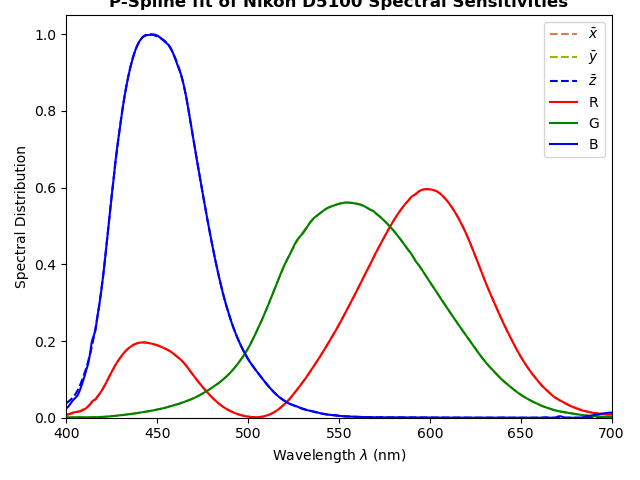

In [20]:
from colour.plotting import plot_multi_sds
from colour import MultiSpectralDistributions
import matplotlib.pyplot as plt
out = spectra.predict(MSDS_TRAIN.values)
out[out<0] = 0
out_spectra = MultiSpectralDistributions(out, SpectralShape(400, 700, 1))
plot_kwargs = [
    {"use_sd_colours": True, "linestyle": "dashed"},
    {"use_sd_colours": True, "linestyle": "dashed"},
    {"use_sd_colours": True, "linestyle": "dashed"},

    {"use_sd_colours": False, "linestyle": "solid", "color": "red", "label": "R"},
    {"use_sd_colours": False, "linestyle": "solid", "color": "green", "label": "G"},
    {"use_sd_colours": False, "linestyle": "solid", "color": "blue", "label": "B"},
]
fig, ax = plot_multi_sds([cmfs, out_spectra], plot_kwargs=plot_kwargs, show=False)
plt.title("P-Spline fit of Nikon D5100 Spectral Sensitivities", weight="bold")
plt.show()


In [32]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(cave_foster2004_dataset.values.T)
print(np.sum(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)

0.986817136812
[ 0.82520032  0.12043595  0.0322493   0.00893157]
